<a href="https://colab.research.google.com/github/syedfahdali/Project-Persona/blob/main/diffusion_controlnet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q diffusers transformers accelerate controlnet_aux safetensors einops
!pip install -q opencv-python Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00


In [2]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, AutoencoderKL, DPMSolverMultistepScheduler
from controlnet_aux import CannyDetector
import matplotlib.pyplot as plt


/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [3]:
# import zipfile
# import os

# # Change this if your file has a different name
# zip_path = "/content/Images.zip"
# extract_dir = "/content/images"

# # Make directory if it doesn't exist
# os.makedirs(extract_dir, exist_ok=True)

# # Extract
# try:
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_dir)
#     print(f"✅ Extracted successfully to: {extract_dir}")
# except zipfile.BadZipFile:
#     print("❌ The uploaded file is not a valid zip file.")


In [4]:
# --- ⚙️ Helper: Render Text to Image ---
def render_text_image(text="WELCOME", font_path="/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",
                      image_size=(512, 512), font_size=180):
    img = Image.new("L", image_size, 255)  # white background
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, font_size)
    text_size = draw.textsize(text, font=font)
    position = ((image_size[0]-text_size[0])//2, (image_size[1]-text_size[1])//2)
    draw.text(position, text, fill=0, font=font)  # black text
    return img

In [5]:
# --- 📸 Convert to Canny Image ---
def get_canny_condition(image_pil):
    image_np = np.array(image_pil)
    edges = cv2.Canny(image_np, 100, 200)
    return Image.fromarray(edges)

In [7]:
# --- 📥 Load Models ---
# ControlNet trained on Canny
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    variant="fp16"
)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# After pipeline creation
pipe.to(device)
controlnet.to(device)



Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_out): Conv2d(256, 320, ker

In [115]:
# --- ⚙️ Helper: Render Text to Image (Updated) ---
def render_text_image(text="WELCOME", font_path="/content/lobster.ttf",
                      image_size=(512, 512), font_size=180):
    img = Image.new("L", image_size, 255)  # white background
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, font_size)

    # Use textbbox instead of deprecated textsize
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    position = ((image_size[0]-text_width)//2, (image_size[1]-text_height)//2)

    draw.text(position, text, fill=0, font=font)
    return img


In [116]:
# Download font if not already done
!wget -q https://github.com/google/fonts/raw/main/ofl/lobster/Lobster-Regular.ttf -O /content/lobster.ttf

# Generate text image using Lobster font
font_path = "/content/lobster.ttf"
# !wget -q https://github.com/google/fonts/raw/main/ofl/bebasneue/BebasNeue-Regular.ttf -O /content/bebas.ttf
# font_path = "/content/bebas.ttf"



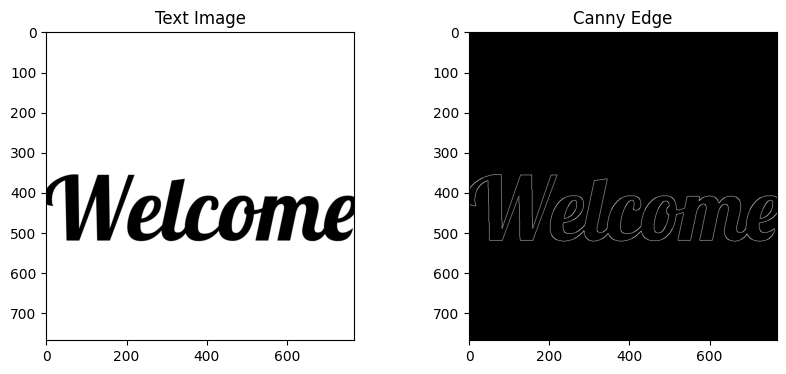

In [127]:
# --- 🖋️ Input Text ---
input_text = "Welcome"
text_img = render_text_image(text=input_text, font_path=font_path)
canny_img = get_canny_condition(text_img)

# Show intermediate
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(text_img, cmap="gray")
plt.title("Text Image")
plt.subplot(1,2,2)
plt.imshow(canny_img, cmap="gray")
plt.title("Canny Edge")
plt.show()

  0%|          | 0/35 [00:00<?, ?it/s]

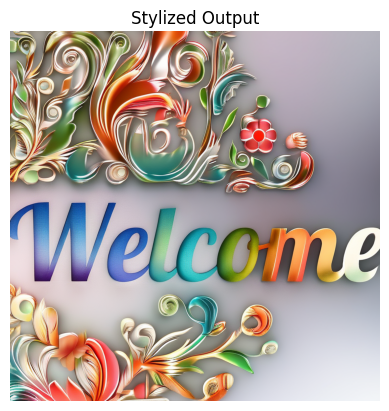

In [128]:
# --- 🎨 Generate Image ---
prompt = (
    f"The word '{input_text}' in large, decorative pop letters extruded outwards, centered on a clean white or soft gradient background. "
    "High contrast, uncluttered background, artistic digital style."
    "Uniform background with no patterns Each letter is filled from inside with vibrant floral patterns and ornamental details. "

)



output = pipe(
    prompt=prompt,
    image=canny_img,
    num_inference_steps=35,
    guidance_scale=7.5,
).images[0]
# --- 💾 Show and Save Result ---
plt.imshow(output)
plt.axis('off')
plt.title("Stylized Output")
plt.show()

output.save("stylized_text_output.png")

In [129]:
def render_text_image(text="Asif", font_path="/content/lobster.ttf",
                      image_size=(768, 768), font_size=220):
    img = Image.new("L", image_size, 255)  # white background
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font_path, font_size)

    # Use textbbox to accurately calculate bounding box
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    position = ((image_size[0] - text_width) // 2, (image_size[1] - text_height) // 2)

    draw.text(position, text, fill=0, font=font)
    return img


In [130]:
canny_img = get_canny_condition(text_img.resize((1024, 1024)))


In [131]:
output = pipe(
    prompt=prompt,
    image=canny_img,
    num_inference_steps=40,
    guidance_scale=10,
    height=1024,
    width=1024
).images[0]


  0%|          | 0/40 [00:00<?, ?it/s]

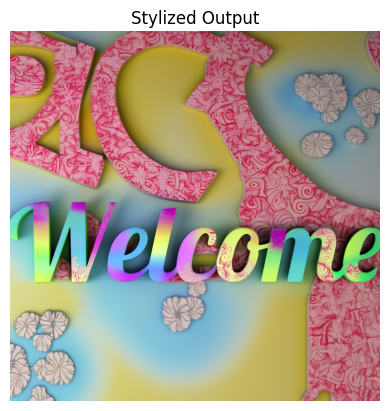

In [132]:
plt.imshow(output)
plt.axis('off')
plt.title("Stylized Output")
plt.show()

output.save("stylized_text_output.png")

In [133]:
def pad_image(pil_img, padding=128):
    """Pad the image on all sides to give SDXL more context to generate wider compositions."""
    w, h = pil_img.size
    new_w, new_h = w + 2 * padding, h + 2 * padding
    padded = Image.new("L", (new_w, new_h), 255)
    padded.paste(pil_img, (padding, padding))
    return padded


In [134]:
text_img = render_text_image(text=input_text, font_path=font_path, image_size=(768, 768), font_size=220)
text_img = pad_image(text_img, padding=128)  # add borders

canny_img = get_canny_condition(text_img)  # apply canny after padding


In [135]:
prompt = (
    f"The word '{input_text}' in large, decorative cursive letters, centered on a clean white or soft gradient background. "
    "Each letter is filled from inside with vibrant floral patterns and ornamental details. "
    "High contrast, uncluttered background, artistic  style."
)


  0%|          | 0/35 [00:00<?, ?it/s]

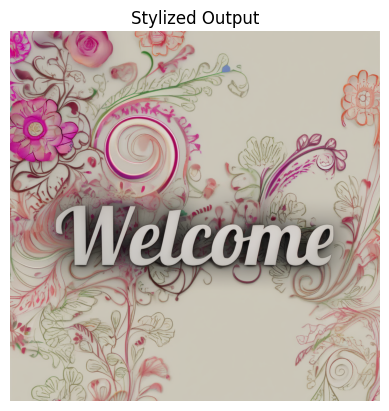

In [136]:
output = pipe(
    prompt=prompt,
    image=canny_img,
    num_inference_steps=35,
    guidance_scale=7.9,
    height=1024,
    width=1024
).images[0]
plt.imshow(output)
plt.axis('off')
plt.title("Stylized Output")
plt.show()

output.save("stylized_text_output.png")
